In [1]:
import networkx as nx
import matplotlib.pyplot as plt
from fullfrlm import flow_refueling_location_model
from generate_network import generate_network
from flow_computation import flow_computation
from random_vessel_generator import random_vessel_generator
from first_stage_frlm import first_stage_frlm
from second_stage_frlm import second_stage_frlm
from create_input_data_abm import create_input_data_abm
from visualize_placement import visualize_placement
from get_abm_data import get_vessel_data_batch, get_cs_data_batch
import pickle
from determine_additional_nodes import determine_additional_nodes
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import time

C:\Users\Fabia\miniconda3\envs\ox\lib\site-packages\osmnx\utils.py:192: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  warnings.warn(


In [2]:
G = pickle.load(open('data/network_cleaned_final.p', 'rb'))
df_h = pickle.load(open("data/revised_cleaning_results/harbour_data_100.p", "rb"))
df_ivs = pickle.load(open("data/revised_cleaning_results/ivs_exploded_100.p", "rb"))
path_lengths = pickle.load(open("data/revised_cleaning_results/path_lengths_ship_specific_routes.p", "rb"))
paths = pickle.load(open('data/final_paths.p', "rb"))

In [3]:
df_ivs.groupby(['origin','destination']).sum().reset_index().sort_values('trip_count', ascending=False)

,origin,destination,trip_count,hour,M12,M8,BII-6b,M10,BIIa-1,M9,...,C4,B04,C2l,BII-2L,B02,C1b,C2b,B01,C1l,route_v
125,NLRTM,NLAMS,9932,825,2076,3510,0,427,102,1316,...,5,5,7,39,4,0,0,0,0,72
141,NLRTM,NLMOE,2685,552,70,1584,0,56,2,144,...,2,0,0,1,0,0,0,0,0,24
150,NLRTM,NLVLI,2151,276,190,658,0,140,10,414,...,0,1,2,0,0,0,1,0,0,0
8,NLAMS,NLAER,2114,275,6,132,0,7,2,0,...,0,37,1,0,3,0,1,1,0,0
179,NLVEG,NLRTM,1467,276,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122,NLPER,NLVLI,92,365,1,20,0,1,0,36,...,0,0,0,0,0,0,0,0,0,23
138,NLRTM,NLLAV,90,269,0,40,0,46,0,0,...,0,0,0,0,0,0,0,0,0,0
108,NLNIJ,NLOMD,87,271,0,23,0,0,30,9,...,0,0,0,20,0,0,0,0,0,0
166,NLTIE,NLVLI,81,269,0,43,0,29,0,5,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# pick seeds
import numpy as np
pick_from = np.linspace(0, 1000000, 1000001)
seeds = np.random.choice(a=pick_from, size=100, replace=False)
seeds = list(seeds)
seeds = [round(i) for i in seeds]

In [5]:
seeds

[76965,
 886368,
 854767,
 648026,
 138467,
 492070,
 831318,
 737902,
 679437,
 372808,
 145338,
 18180,
 459695,
 872390,
 397054,
 37183,
 606418,
 467610,
 217693,
 75582,
 983270,
 73572,
 823561,
 740610,
 382362,
 835115,
 454854,
 342701,
 123895,
 428418,
 313133,
 543006,
 18447,
 408210,
 951505,
 314574,
 659547,
 255519,
 343884,
 96074,
 953675,
 971197,
 582367,
 441887,
 581704,
 497271,
 666463,
 28819,
 115727,
 654685,
 816473,
 209657,
 146618,
 729011,
 976213,
 343716,
 928589,
 264978,
 170158,
 724747,
 899638,
 164433,
 68263,
 453764,
 915760,
 443726,
 44895,
 561600,
 287265,
 690164,
 861724,
 699116,
 867988,
 566865,
 134444,
 512095,
 760057,
 77896,
 543539,
 268797,
 347926,
 615877,
 187627,
 700356,
 169675,
 152093,
 150927,
 303832,
 278486,
 227973,
 345480,
 137351,
 127004,
 826241,
 776226,
 791676,
 686771,
 6054,
 926586,
 572179]

In [6]:
seeds = [259572, 7542, 864199, 11540, 188813, 411862, 546078, 420812, 304196, 814030]

Optimal
CPU times: total: 25.1 s
Wall time: 25.4 s


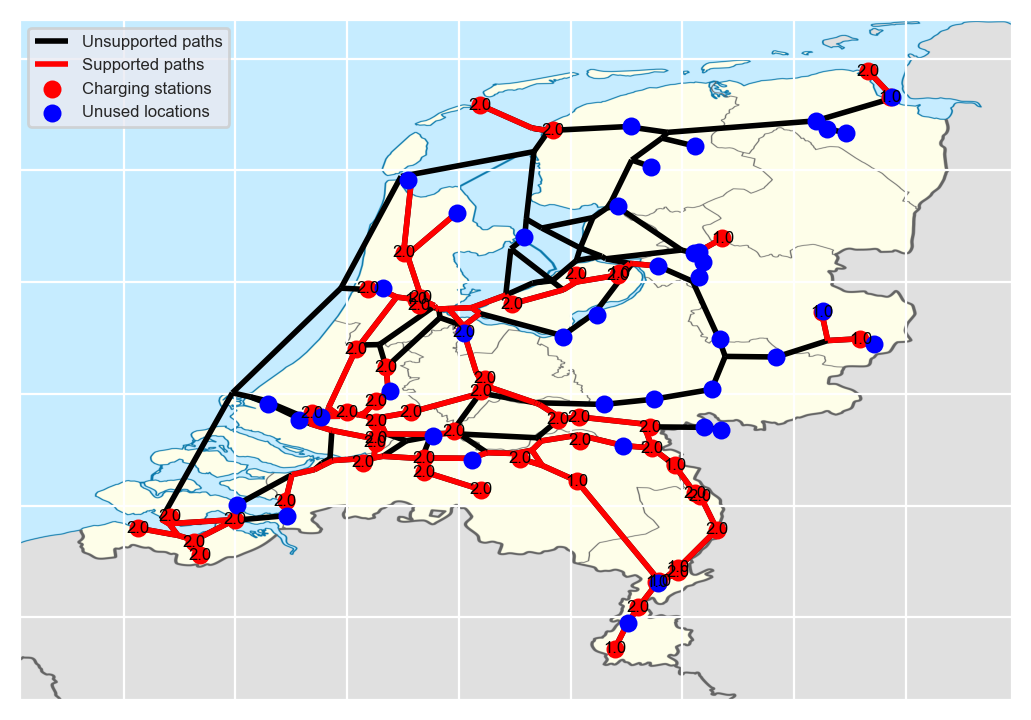

In [7]:
%%time
total_flow, fraction_captured_total, serviceable_fraction, served_fraction, optimal_facilities, \
    non_zero_flows, routes_supported, paths, G, df_abm, df_random_out, max_flow = flow_refueling_location_model(1, seeds[0], 150000, 15000, 175, 100, 600, 2, 24, False, False, False, True)

In [8]:
serviceable_fraction

0.8998629843542311

In [9]:
non_zero_flows

{('NLABL', 'NLRTM', 0): {'combinations': [['8866686']], 'flows': [1.0]},
 ('NLAER', 'NLLEY', 0): {'combinations': [['8863709']], 'flows': [0.88257959]},
 ('NLAER', 'NLSWI', 0): {'combinations': [['8868266']], 'flows': [1.0]},
 ('NLALK',
  'NLIJM',
  0): {'combinations': [['8861625'],
   ['8862497'],
   ['8863260']], 'flows': [0.18033218, 0.73126186, 0.088405951]},
 ('NLALM', 'NLHGL', 0): {'combinations': [['8864153']], 'flows': [1.0]},
 ('NLAMS', 'NLAER', 0): {'combinations': [['8866763']], 'flows': [0.17416576]},
 ('NLAMS', 'NLDHR', 0): {'combinations': [['8861625']], 'flows': [0.75646966]},
 ('NLAMS', 'NLIJM', 0): {'combinations': [['8862497']], 'flows': [1.0]},
 ('NLAMS', 'NLNWG', 0): {'combinations': [['8867392']], 'flows': [0.53047723]},
 ('NLAMS',
  'NLVLA',
  1): {'combinations': [['8863260', '30986190'],
   ['8866564']], 'flows': [0.11722264, 0.21951343]},
 ('NLAMS', 'NLWMO', 0): {'combinations': [['8866889']], 'flows': [1.0]},
 ('NLAMS', 'NLZAA', 0): {'combinations': [['886688

In [ ]:
df_h = pickle.load(open("data/revised_cleaning_results/harbour_data_100.p", "rb"))
facilities = [i for i in optimal_facilities.keys() if optimal_facilities[i] > 0]

extra_nodes_used = list(set(facilities)-set(list(df_h.harbour_node)))

In [ ]:
print(total_flow, fraction_captured_total, serviceable_fraction, served_fraction, routes_supported)

# Complete batch run first before continuing
Run file batchrun.py in ABM/ownwork

## Rerun using feedback from ABM

In [ ]:
vessel_data_abm = get_vessel_data_batch()

In [ ]:
station_data_abm = get_cs_data_batch()

In [ ]:
station_data_abm

In [ ]:
top5_least_used = list(station_data_abm.sort_values(by='occupation').head(5).index)

In [ ]:
top5_least_used

In [ ]:
%%time
total_flow, fraction_captured_total, serveable_fraction, served_fraction, optimal_facilities, \
non_zero_flows, routes_supported, paths, G, df_abm, df_random_out = flow_refueling_location_model(load, 70000, 40, 1000, 2, df_random, False, False, True, top5_least_used)

In [ ]:
facilities = [i for i in optimal_facilities.keys() if optimal_facilities[i] > 0]
extra_nodes_used = list(set(facilities) - set(list(df_h.harbour_node)))
extra_nodes_used

In [ ]:

print(total_flow, fraction_captured_total, serveable_fraction, served_fraction, routes_supported)

## Now simulate again

## Stepwise run of all components of frlm

### Load necessary data

In [ ]:
df_h = pickle.load(open("data/revised_cleaning_results/harbour_data_100.p", "rb"))
df_ivs = pickle.load(open("data/revised_cleaning_results/ivs_exploded_100.p", "rb"))
path_lengths = pickle.load(open("data/revised_cleaning_results/path_lengths_ship_specific_routes.p", "rb"))

In [ ]:
df_ivs

## Generate random df

In [ ]:
%%time
df_chance = df_ivs.copy()
df_random1 = random_vessel_generator(df_chance, 1)

In [ ]:
df_random1


## Compute path flows

In [ ]:
%%time
flows = flow_computation(df_random1)

In [ ]:
sum(flows.values())

## Generate network

In [ ]:
%%time
G = pickle.load(open('data/network_cleaned_final.p', 'rb'))
paths = pickle.load(open("data/final_paths.p", "rb"))
G, paths, inserted_nodes = generate_network(G, paths, 70000)

In [ ]:
inserted_nodes += determine_additional_nodes(G, df_h, 70000)

In [ ]:
inserted_nodes

In [ ]:
%%time
# range r in meters
df_b, df_g, df_eq_fq, feasible_combinations = first_stage_frlm(70000, G, OD=flows, paths=paths, path_lengths=path_lengths, df_h=df_h, additional_nodes=inserted_nodes)

## Run second stage FRLM

In [ ]:
%%time
optimal_facilities, optimal_flows, non_zero_flows, supported_flow, routes_supported = second_stage_frlm(70000, 15000, 175, 40, 2500, 2, df_g, df_b, df_eq_fq)

In [ ]:
optimal_facilities

In [ ]:
sum(optimal_facilities.values())

In [ ]:
sum(optimal_flows.values())

In [ ]:
supported_flow

## Create input data ABM

In [ ]:
%%time
df_abm = create_input_data_abm(G, paths, non_zero_flows, optimal_facilities)

In [ ]:
df_abm

## Visualize placement

In [ ]:
visualize_placement(G,flows, optimal_facilities, non_zero_flows, df_h, paths, True)